# Different GPS Spoofing Parameters
This notebook looks at different parameters for spoofing the GPS while the UAV
is idle.

The data files can be found in the data subdirectory. Only interim data will be
available on github to preserve storage. For raw log files please contact me at
srimoungchanh.bailey@ku.edu.

In [1]:
benign_dist = 7.348

## 1) Loading 1m offset with 0.40 m/s/s slow rate Data

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import numpy as np
from confirmation.process import process_SNS
from os.path import exists

#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Live-C-Idle-Attack-1m-0_4mss.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
ofMS['ofMS'] = pd.to_datetime(ofMS['ofMS'], unit='ms')
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
magUS['magUS'] = pd.to_datetime(magUS['magUS'], unit='us')
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')
rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf","m22"]].reset_index(drop=True)
rfMS['rfMS'] = pd.to_datetime(rfMS['rfMS'], unit='ms')

attack_start = pd.to_datetime(184627473, unit='us')
attack_end = pd.to_datetime(196199871, unit='us')

### Velocity

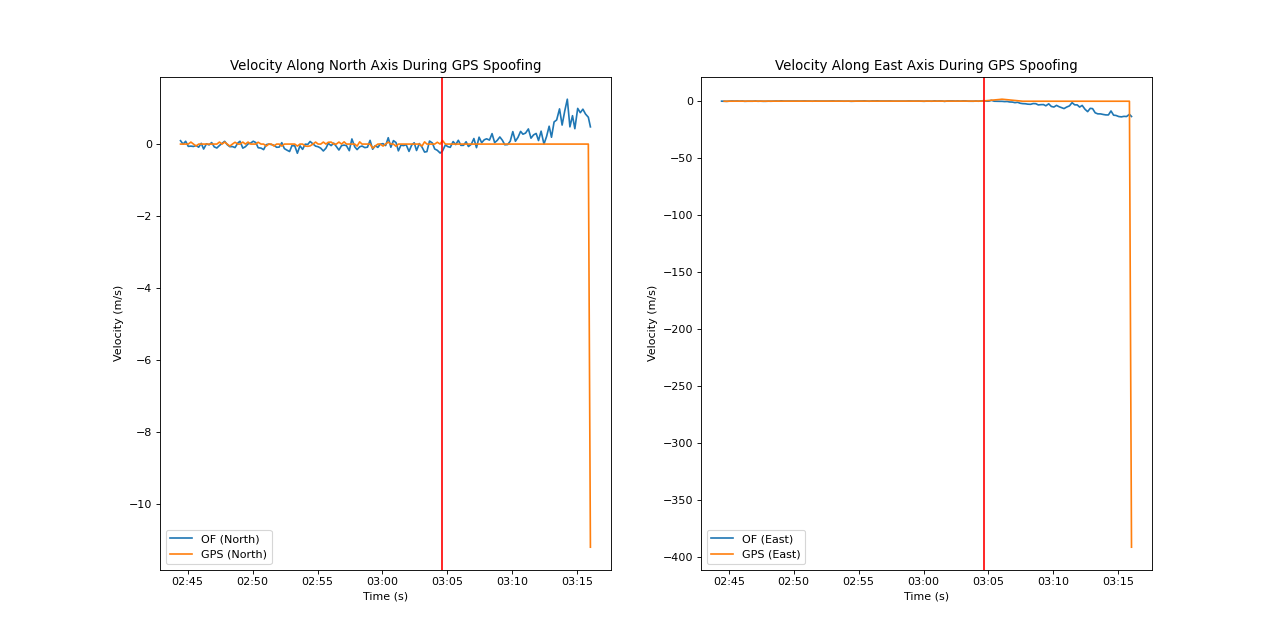

In [3]:
from confirmation.process import geodetic2ned
from confirmation.process import body_to_earth2D, low_pass_filter
from confirmation.process import signal_match_and_cumsum, change_in_signal
import matplotlib.pyplot as plt
from matplotlib import dates
from scipy.integrate import trapezoid

gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

#Convert optical flow and rangefinder to OF Velocity in body frame
of_vel_bf = pd.DataFrame(data={"OF Forward":(ofMS.frF - ofMS.brF) * ofMS.rf/100,
                               "OF Right":(ofMS.frR - ofMS.brR) * ofMS.rf/100})

earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)

lpf_E = -low_pass_filter(earth_frame.East, alpha=0.2)
lpf_N = low_pass_filter(earth_frame.North, alpha=0.2)

gps_east = pd.Series(gps_east)
lpf_E = pd.Series(lpf_E)
gps_north = pd.Series(gps_north)
lpf_N = pd.Series(lpf_N)

#Matching OF to the GPS update rate
of_east = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_E),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_east)
of_east = pd.Series(of_east, name="OF East, LPF")
of_north = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_N),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_north)
of_north = pd.Series(of_north, name="OF North, LPF")

plt.figure(figsize=(16, 8), dpi=80)
ax = plt.subplot(1, 2, 1)
plt1 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_north[:(gpsMS.gpsMS < attack_end).sum()]-of_north[1], label="OF (North)")
plt2 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], gps_north[:(gpsMS.gpsMS < attack_end).sum()], label="GPS (North)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along North Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
ax = plt.subplot(1, 2, 2)
plt3 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_east[:(gpsMS.gpsMS < attack_end).sum()]-of_east[1], label="OF (East)")
plt4 = plt.plot(gpsMS.gpsMS[1:(gpsMS.gpsMS < attack_end).sum()], gps_east[1:(gpsMS.gpsMS < attack_end).sum()], label="GPS (East)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along East Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
plt.show()

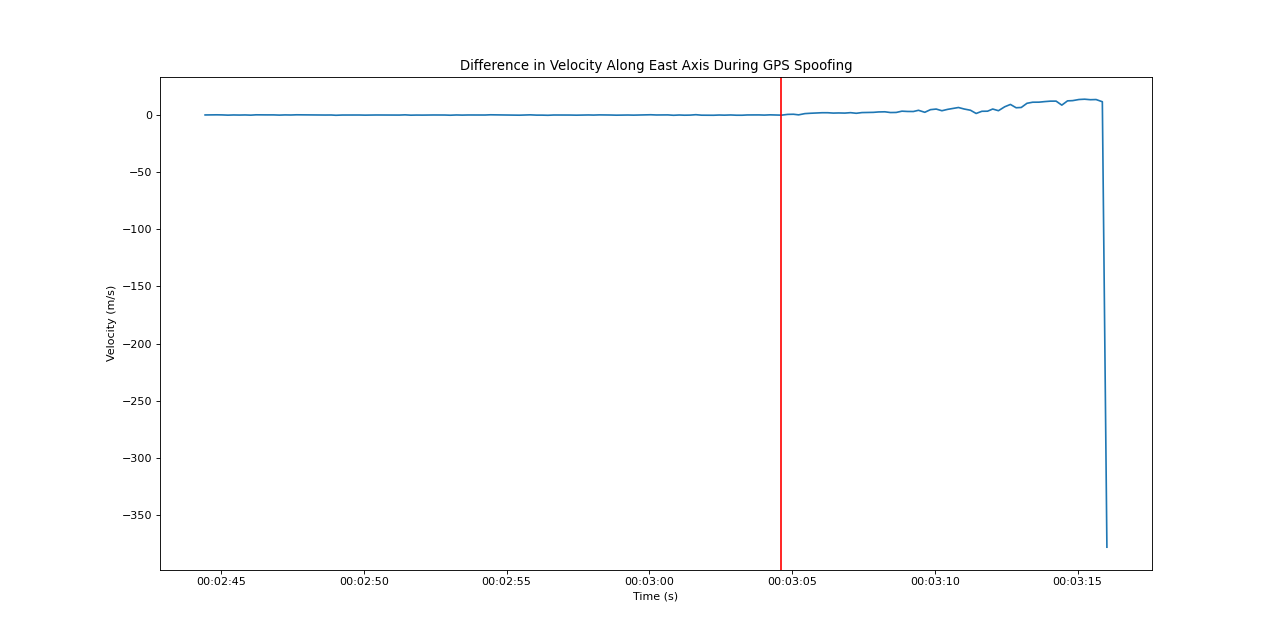

In [4]:
plt.figure(figsize=(16, 8), dpi=80)
diff = (gps_east - of_east)[:(gpsMS.gpsMS < attack_end).sum()]
plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], diff)
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Difference in Velocity Along East Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))

In [5]:
print("Max difference between GPS and OF before attack is %f m/s and after attack is %f m/s" % (
        abs(gps_east - of_east)[gpsMS.gpsMS < attack_start].max(),
        abs(gps_east - of_east)[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Max difference between GPS and OF before attack is 0.282841 m/s and after attack is 378.073036 m/s


In [6]:
dt = (gpsMS.gpsMS[diff[diff>benign_dist].index[0]] - attack_start).total_seconds()
print("Time until detection: %fs" % dt)

Time until detection: 8.019527s


In [7]:
OF_Vel = of_east[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
OF_ts = gpsMS.gpsMS[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
print("Distance traveled until detection according to Optical Flow: %fm" % abs(trapezoid(y=OF_Vel, x=OF_ts.diff().dt.total_seconds().fillna(0).cumsum())))

Distance traveled until detection according to Optical Flow: 19.221903m


## 2) Loading 1m offset with 0.25 m/s/s slow rate Data

In [8]:
#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Live-C-Idle-Attack-1m-0_25mss.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
ofMS['ofMS'] = pd.to_datetime(ofMS['ofMS'], unit='ms')
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
magUS['magUS'] = pd.to_datetime(magUS['magUS'], unit='us')
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')
rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf","m22"]].reset_index(drop=True)
rfMS['rfMS'] = pd.to_datetime(rfMS['rfMS'], unit='ms')

attack_start = pd.to_datetime(171902803, unit='us')
attack_end = pd.to_datetime(184020977, unit='us')

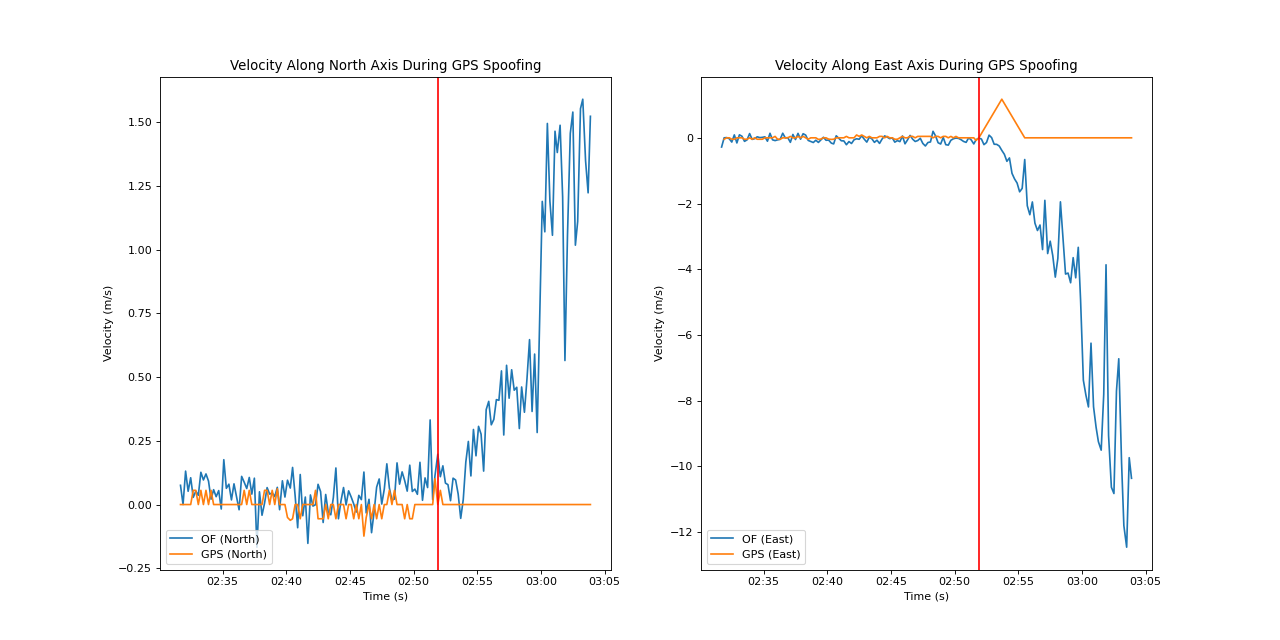

In [9]:
gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

#Convert optical flow and rangefinder to OF Velocity in body frame
of_vel_bf = pd.DataFrame(data={"OF Forward":(ofMS.frF - ofMS.brF) * ofMS.rf/100,
                               "OF Right":(ofMS.frR - ofMS.brR) * ofMS.rf/100})

earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)

lpf_E = -low_pass_filter(earth_frame.East, alpha=0.2)
lpf_N = low_pass_filter(earth_frame.North, alpha=0.2)

gps_east = pd.Series(gps_east)
lpf_E = pd.Series(lpf_E)
gps_north = pd.Series(gps_north)
lpf_N = pd.Series(lpf_N)

#Matching OF to the GPS update rate
of_east = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_E),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_east)
of_east = pd.Series(of_east, name="OF East, LPF")
of_north = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_N),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_north)
of_north = pd.Series(of_north, name="OF North, LPF")

plt.figure(figsize=(16, 8), dpi=80)
ax = plt.subplot(1, 2, 1)
plt1 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_north[:(gpsMS.gpsMS < attack_end).sum()]-of_north[1], label="OF (North)")
plt2 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], gps_north[:(gpsMS.gpsMS < attack_end).sum()], label="GPS (North)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along North Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
ax = plt.subplot(1, 2, 2)
plt3 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_east[:(gpsMS.gpsMS < attack_end).sum()]-of_east[1], label="OF (East)")
plt4 = plt.plot(gpsMS.gpsMS[1:(gpsMS.gpsMS < attack_end).sum()], gps_east[1:(gpsMS.gpsMS < attack_end).sum()], label="GPS (East)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along East Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
plt.show()

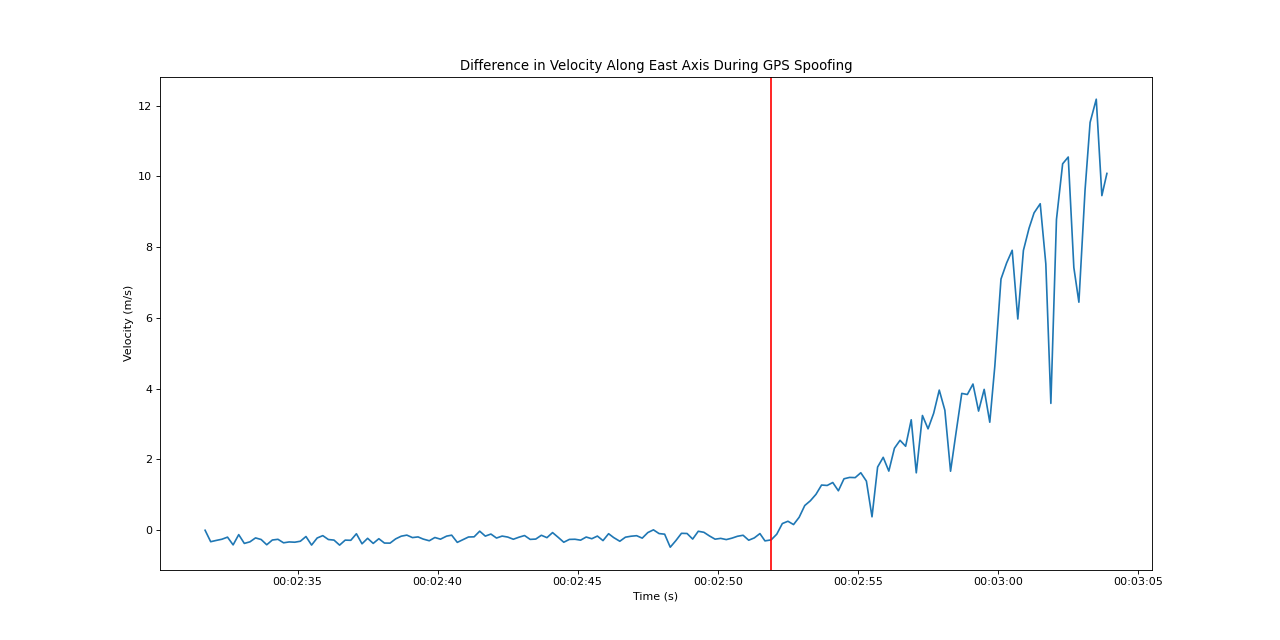

In [10]:
plt.figure(figsize=(16, 8), dpi=80)
diff = (gps_east - of_east)[:(gpsMS.gpsMS < attack_end).sum()]
plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], diff)
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Difference in Velocity Along East Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))

In [11]:
print("Max difference between GPS and OF before attack is %f m/s and after attack is %f m/s" % (
        abs(gps_east - of_east)[gpsMS.gpsMS < attack_start].max(),
        abs(gps_east - of_east)[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Max difference between GPS and OF before attack is 0.479154 m/s and after attack is 12.181719 m/s


In [12]:
dt = (gpsMS.gpsMS[diff[diff>benign_dist].index[0]] - attack_start).total_seconds()
print("Time until detection: %fs" % dt)

Time until detection: 8.402197s


In [13]:
OF_Vel = of_east[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
OF_ts = gpsMS.gpsMS[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
print("Distance traveled until detection according to Optical Flow: %fm" % abs(trapezoid(y=OF_Vel, x=OF_ts.diff().dt.total_seconds().fillna(0).cumsum())))

Distance traveled until detection according to Optical Flow: 15.031393m


## 3) Loading 0.5m offset with 0.25 m/s/s slow rate Data

In [14]:
#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Live-C-Idle-Attack-0_5m-0_25mss.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
ofMS['ofMS'] = pd.to_datetime(ofMS['ofMS'], unit='ms')
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
magUS['magUS'] = pd.to_datetime(magUS['magUS'], unit='us')
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')
rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf","m22"]].reset_index(drop=True)
rfMS['rfMS'] = pd.to_datetime(rfMS['rfMS'], unit='ms')

attack_start = pd.to_datetime(162088483, unit='us')
attack_end = pd.to_datetime(178158899, unit='us')

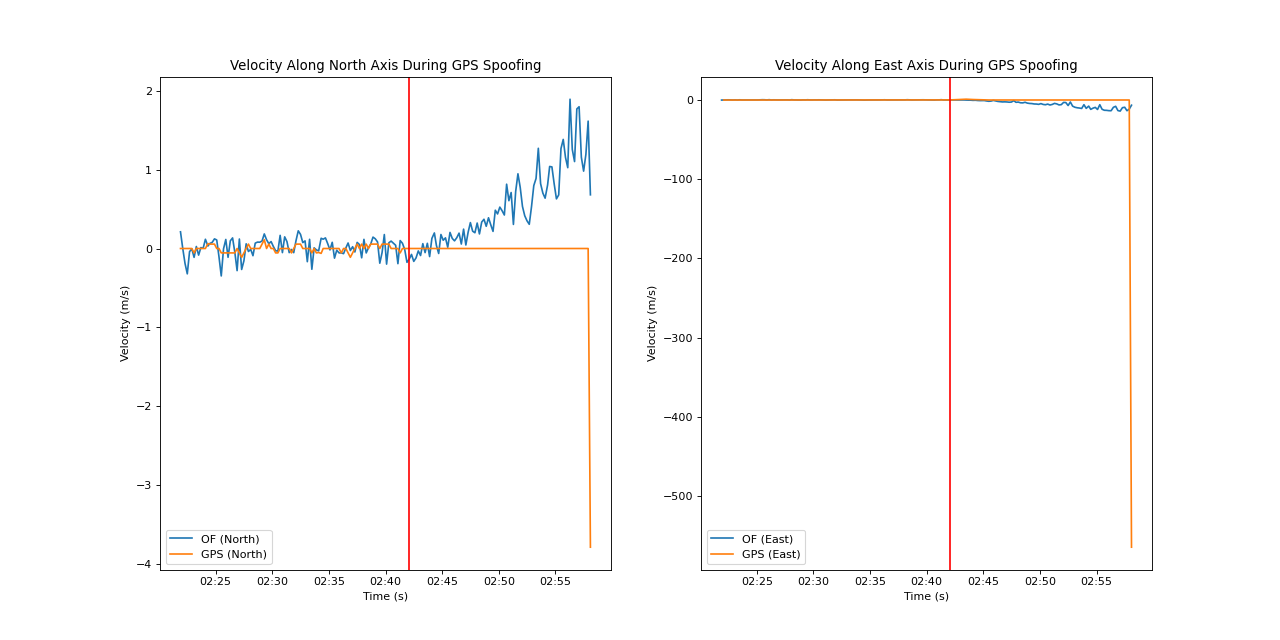

In [15]:
gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

#Convert optical flow and rangefinder to OF Velocity in body frame
of_vel_bf = pd.DataFrame(data={"OF Forward":(ofMS.frF - ofMS.brF) * ofMS.rf/100,
                               "OF Right":(ofMS.frR - ofMS.brR) * ofMS.rf/100})

earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)

lpf_E = -low_pass_filter(earth_frame.East, alpha=0.2)
lpf_N = low_pass_filter(earth_frame.North, alpha=0.2)

gps_east = pd.Series(gps_east)
lpf_E = pd.Series(lpf_E)
gps_north = pd.Series(gps_north)
lpf_N = pd.Series(lpf_N)

#Matching OF to the GPS update rate
of_east = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_E),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_east)
of_east = pd.Series(of_east, name="OF East, LPF")
of_north = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_N),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_north)
of_north = pd.Series(of_north, name="OF North, LPF")

plt.figure(figsize=(16, 8), dpi=80)
ax = plt.subplot(1, 2, 1)
plt1 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_north[:(gpsMS.gpsMS < attack_end).sum()]-of_north[1], label="OF (North)")
plt2 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], gps_north[:(gpsMS.gpsMS < attack_end).sum()], label="GPS (North)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along North Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
ax = plt.subplot(1, 2, 2)
plt3 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_east[:(gpsMS.gpsMS < attack_end).sum()]-of_east[1], label="OF (East)")
plt4 = plt.plot(gpsMS.gpsMS[1:(gpsMS.gpsMS < attack_end).sum()], gps_east[1:(gpsMS.gpsMS < attack_end).sum()], label="GPS (East)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along East Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
plt.show()

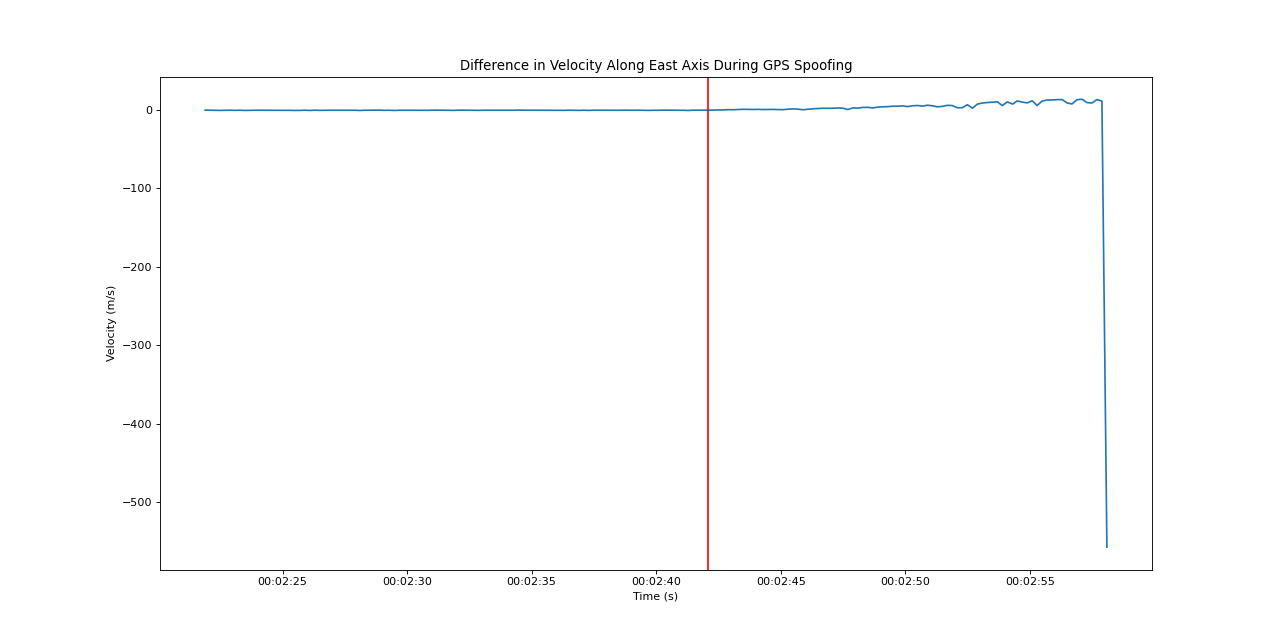

In [16]:
plt.figure(figsize=(16, 8), dpi=80)
diff = (gps_east - of_east)[:(gpsMS.gpsMS < attack_end).sum()]
plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], diff)
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Difference in Velocity Along East Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))

In [17]:
print("Max difference between GPS and OF before attack is %f m/s and after attack is %f m/s" % (
        abs(gps_east - of_east)[gpsMS.gpsMS < attack_start].max(),
        abs(gps_east - of_east)[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Max difference between GPS and OF before attack is 0.467075 m/s and after attack is 557.783465 m/s


In [18]:
dt = (gpsMS.gpsMS[diff[diff>benign_dist].index[0]] - attack_start).total_seconds()
print("Time until detection: %fs" % dt)

Time until detection: 10.799517s


In [19]:
OF_Vel = of_east[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
OF_ts = gpsMS.gpsMS[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
print("Distance traveled until detection according to Optical Flow: %fm" % abs(trapezoid(y=OF_Vel, x=OF_ts.diff().dt.total_seconds().fillna(0).cumsum())))

Distance traveled until detection according to Optical Flow: 27.097406m


## 4) Loading 0.5m offset with 0.10 m/s/s slow rate Data

In [20]:
#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Live-C-Idle-Attack-0_5m-0_1mss.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
ofMS['ofMS'] = pd.to_datetime(ofMS['ofMS'], unit='ms')
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
magUS['magUS'] = pd.to_datetime(magUS['magUS'], unit='us')
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')
rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf","m22"]].reset_index(drop=True)
rfMS['rfMS'] = pd.to_datetime(rfMS['rfMS'], unit='ms')

attack_start = pd.to_datetime(197240832, unit='us')
attack_end = pd.to_datetime(212816567, unit='us')

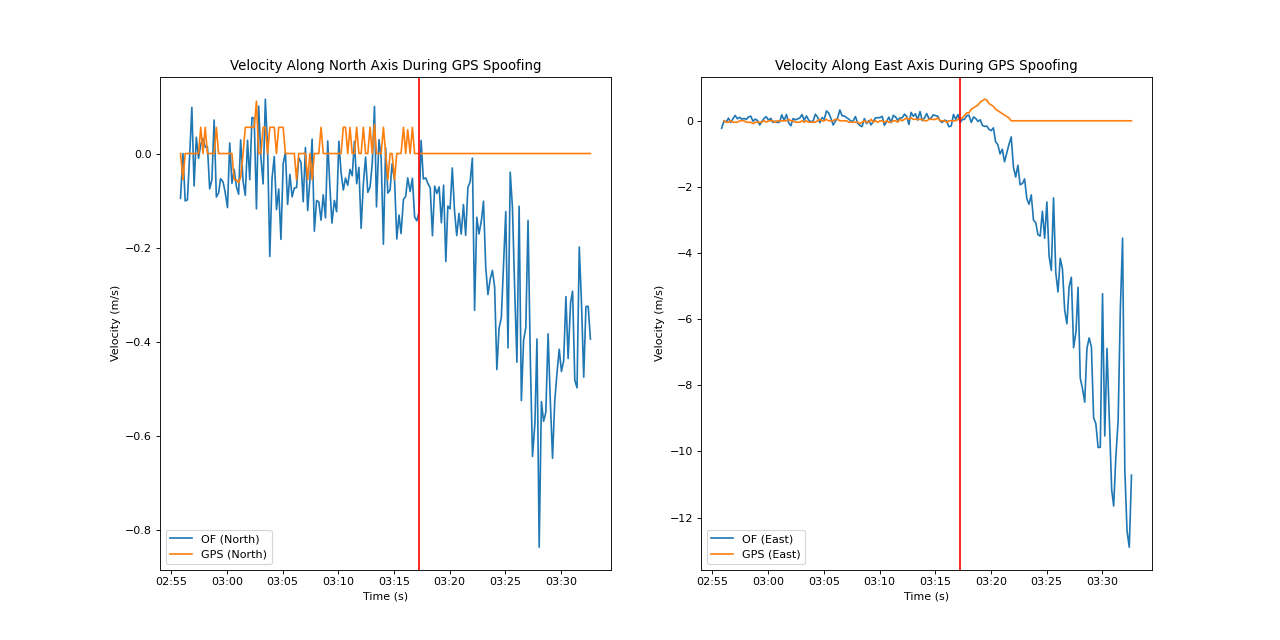

In [21]:
gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

#Convert optical flow and rangefinder to OF Velocity in body frame
of_vel_bf = pd.DataFrame(data={"OF Forward":(ofMS.frF - ofMS.brF) * ofMS.rf/100,
                               "OF Right":(ofMS.frR - ofMS.brR) * ofMS.rf/100})

earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)

lpf_E = -low_pass_filter(earth_frame.East, alpha=0.2)
lpf_N = low_pass_filter(earth_frame.North, alpha=0.2)

gps_east = pd.Series(gps_east)
lpf_E = pd.Series(lpf_E)
gps_north = pd.Series(gps_north)
lpf_N = pd.Series(lpf_N)

#Matching OF to the GPS update rate
of_east = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_E),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_east)
of_east = pd.Series(of_east, name="OF East, LPF")
of_north = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_N),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_north)
of_north = pd.Series(of_north, name="OF North, LPF")

plt.figure(figsize=(16, 8), dpi=80)
ax = plt.subplot(1, 2, 1)
plt1 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_north[:(gpsMS.gpsMS < attack_end).sum()]-of_north[1], label="OF (North)")
plt2 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], gps_north[:(gpsMS.gpsMS < attack_end).sum()], label="GPS (North)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along North Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
ax = plt.subplot(1, 2, 2)
plt3 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_east[:(gpsMS.gpsMS < attack_end).sum()]-of_east[1], label="OF (East)")
plt4 = plt.plot(gpsMS.gpsMS[1:(gpsMS.gpsMS < attack_end).sum()], gps_east[1:(gpsMS.gpsMS < attack_end).sum()], label="GPS (East)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along East Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
plt.show()

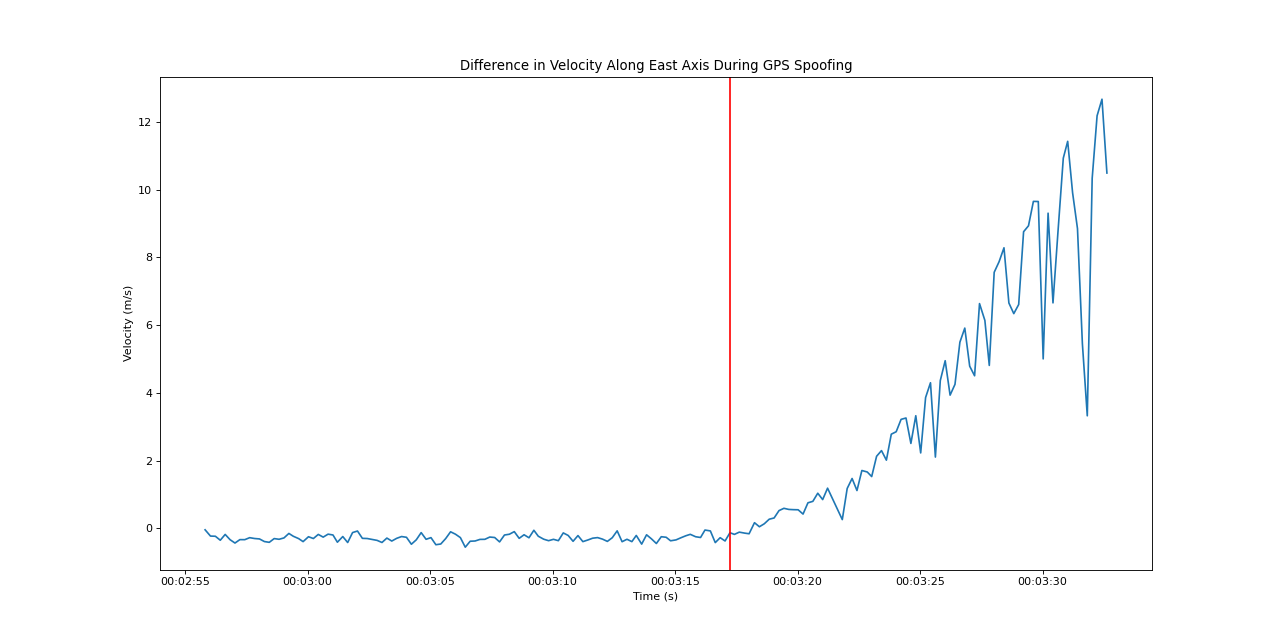

In [22]:
plt.figure(figsize=(16, 8), dpi=80)
diff = (gps_east - of_east)[:(gpsMS.gpsMS < attack_end).sum()]
plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], diff)
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Difference in Velocity Along East Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))

In [23]:
print("Max difference between GPS and OF before attack is %f m/s and after attack is %f m/s" % (
        abs(gps_east - of_east)[gpsMS.gpsMS < attack_start].max(),
        abs(gps_east - of_east)[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Max difference between GPS and OF before attack is 0.553366 m/s and after attack is 12.672761 m/s


In [24]:
dt = (gpsMS.gpsMS[diff[diff>benign_dist].index[0]] - attack_start).total_seconds()
print("Time until detection: %fs" % dt)

Time until detection: 10.784168s


In [25]:
OF_Vel = of_east[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
OF_ts = gpsMS.gpsMS[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
print("Distance traveled until detection according to Optical Flow: %fm" % abs(trapezoid(y=OF_Vel, x=OF_ts.diff().dt.total_seconds().fillna(0).cumsum())))

Distance traveled until detection according to Optical Flow: 20.271472m


## 5) Loading 0.25m offset with 0.10 m/s/s slow rate Data

In [26]:
#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Live-C-Idle-Attack-0_25m-0_1mss.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
ofMS['ofMS'] = pd.to_datetime(ofMS['ofMS'], unit='ms')
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
magUS['magUS'] = pd.to_datetime(magUS['magUS'], unit='us')
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')
rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf","m22"]].reset_index(drop=True)
rfMS['rfMS'] = pd.to_datetime(rfMS['rfMS'], unit='ms')

attack_start = pd.to_datetime(172223342, unit='us')
attack_end = pd.to_datetime(194779194, unit='us')

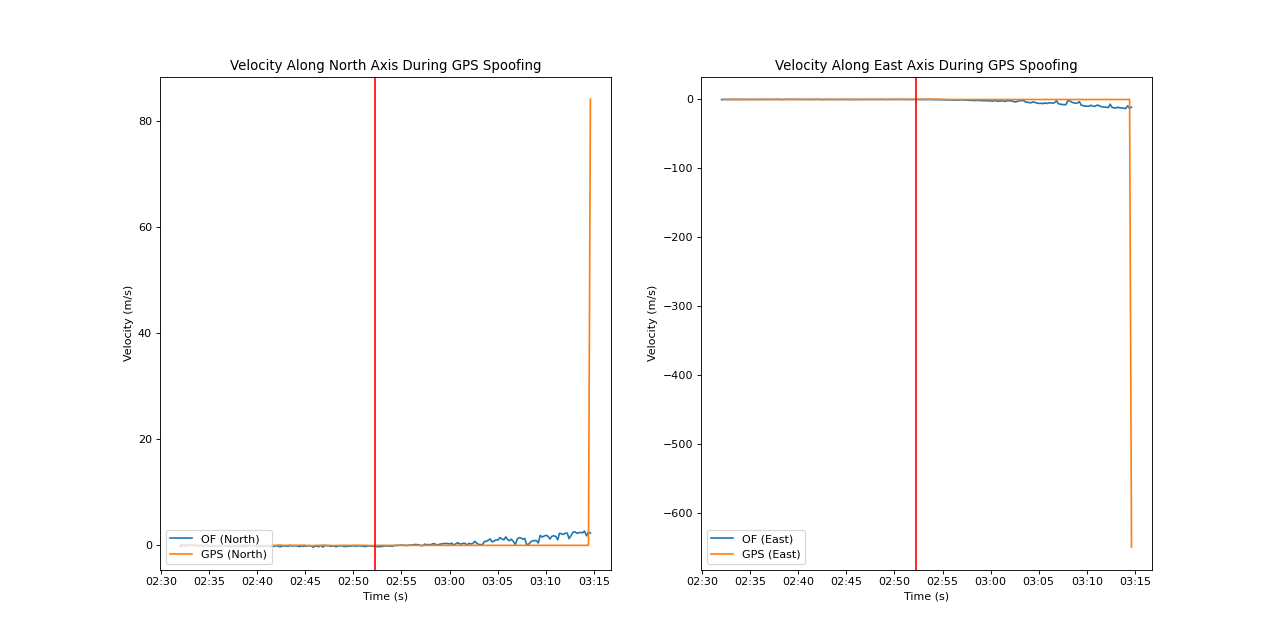

In [27]:
gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

#Convert optical flow and rangefinder to OF Velocity in body frame
of_vel_bf = pd.DataFrame(data={"OF Forward":(ofMS.frF - ofMS.brF) * ofMS.rf/100,
                               "OF Right":(ofMS.frR - ofMS.brR) * ofMS.rf/100})

earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)

lpf_E = -low_pass_filter(earth_frame.East, alpha=0.2)
lpf_N = low_pass_filter(earth_frame.North, alpha=0.2)

gps_east = pd.Series(gps_east)
lpf_E = pd.Series(lpf_E)
gps_north = pd.Series(gps_north)
lpf_N = pd.Series(lpf_N)

#Matching OF to the GPS update rate
of_east = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_E),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_east)
of_east = pd.Series(of_east, name="OF East, LPF")
of_north = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_N),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_north)
of_north = pd.Series(of_north, name="OF North, LPF")

plt.figure(figsize=(16, 8), dpi=80)
ax = plt.subplot(1, 2, 1)
plt1 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_north[:(gpsMS.gpsMS < attack_end).sum()]-of_north[1], label="OF (North)")
plt2 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], gps_north[:(gpsMS.gpsMS < attack_end).sum()], label="GPS (North)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along North Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
ax = plt.subplot(1, 2, 2)
plt3 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_east[:(gpsMS.gpsMS < attack_end).sum()]-of_east[1], label="OF (East)")
plt4 = plt.plot(gpsMS.gpsMS[1:(gpsMS.gpsMS < attack_end).sum()], gps_east[1:(gpsMS.gpsMS < attack_end).sum()], label="GPS (East)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along East Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
plt.show()

In [28]:
pd.DataFrame(data=[list(plt1[0].get_data()[0].astype(float)),
                   list(plt1[0].get_data()[1]),
                   list(plt2[0].get_data()[1]),]).transpose().to_csv("0_25m-0_10_North.csv")

pd.DataFrame(data=[list(plt3[0].get_data()[0].astype(float)),
                   list(plt3[0].get_data()[1]),
                   list(plt4[0].get_data()[1]),]).transpose().to_csv("0_25m-0_10_East.csv")

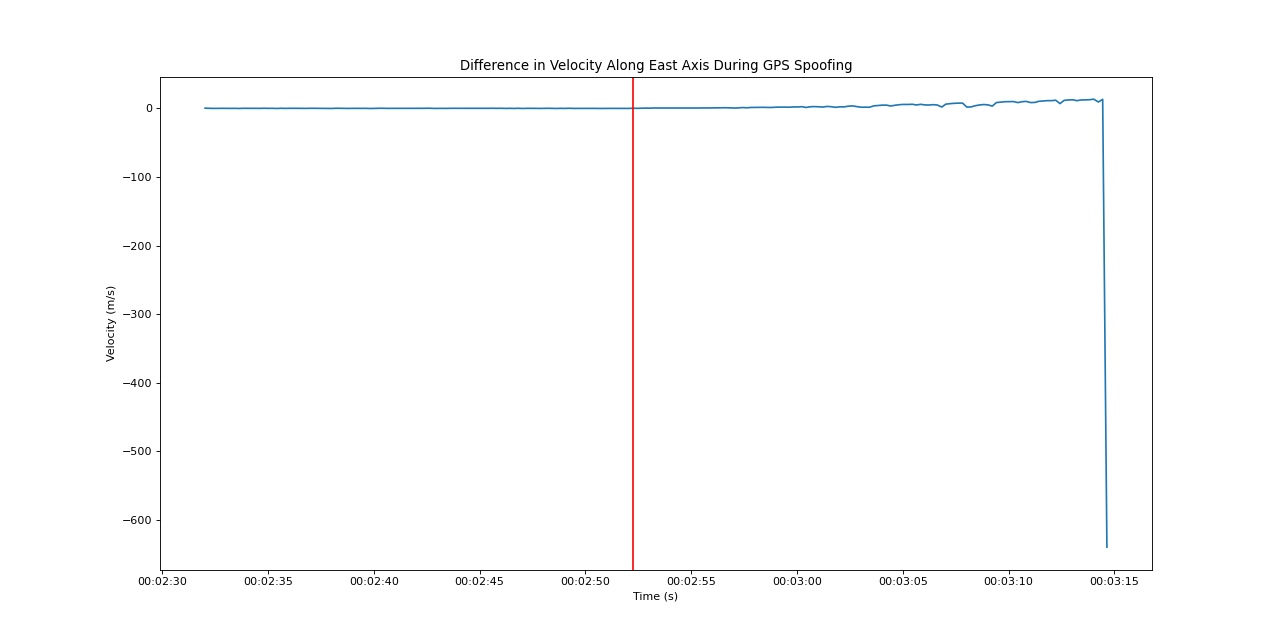

In [29]:
plt.figure(figsize=(16, 8), dpi=80)
diff = (gps_east - of_east)[:(gpsMS.gpsMS < attack_end).sum()]
plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], diff)
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Difference in Velocity Along East Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))

In [30]:
print("Max difference between GPS and OF before attack is %f m/s and after attack is %f m/s" % (
        abs(gps_east - of_east)[gpsMS.gpsMS < attack_start].max(),
        abs(gps_east - of_east)[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Max difference between GPS and OF before attack is 0.421169 m/s and after attack is 639.402452 m/s


In [31]:
dt = (gpsMS.gpsMS[diff[diff>benign_dist].index[0]] - attack_start).total_seconds()
print("Time until detection: %fs" % dt)

Time until detection: 15.399658s


In [32]:
OF_Vel = of_east[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
OF_ts = gpsMS.gpsMS[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
print("Distance traveled until detection according to Optical Flow: %fm" % abs(trapezoid(y=OF_Vel, x=OF_ts.diff().dt.total_seconds().fillna(0).cumsum())))

Distance traveled until detection according to Optical Flow: 29.873768m
